# Linear System Model

In [1]:
!pyomo --version

Pyomo 6.8.2 (CPython 3.10.16 on Darwin 24.3.0)


## Define Dynamical System

In [2]:
from pyomo.environ import ConcreteModel, Var, Param, Constraint, SolverFactory, TransformationFactory, Suffix, value
from pyomo.dae import ContinuousSet, DerivativeVar, Simulator

# Create a model
model = ConcreteModel()

# Define time
model.t = ContinuousSet(bounds=(0, 10))

# Define variables
model.x1 = Var(model.t, bounds=(-30,30))
model.x2 = Var(model.t, bounds=(-30,30))
model.u = Var(model.t, bounds=(-2,2))

# Define derivatives
model.dx1dt = DerivativeVar(model.x1, wrt=model.t)
model.dx2dt = DerivativeVar(model.x2, wrt=model.t)

# Define parameters
model.a11 = Param(initialize=-1.0)
model.a12 = Param(initialize=1.0)
model.a21 = Param(initialize=0.0)
model.a22 = Param(initialize=-2.0)
model.b1 = Param(initialize=0)
model.b2 = Param(initialize=1)

# Define differential equations
def _ode1(m, t):
    return m.dx1dt[t] == m.a11 * m.x1[t] + m.a12*m.x2[t] + m.b1 * m.u[t]
model.ode1 = Constraint(model.t, rule=_ode1)

def _ode2(m, t):
    return m.dx2dt[t] == m.a21 * m.x1[t] + m.a22*m.x2[t] + m.b2 * m.u[t]
model.ode2 = Constraint(model.t, rule=_ode2)

# Define initial conditions
model.x1[0].fix(0)
model.x2[0].fix(0)

# Discretize the model using finite difference method
discretizer = TransformationFactory('dae.finite_difference')
discretizer.apply_to(model, nfe=30, scheme='BACKWARD')

for t in model.t:
    model.u[t].fix(-1)

# Solve the model
solver = SolverFactory('ipopt')
solver.solve(model, tee=True)

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

{'Problem': [{'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 122, 'Number of variables': 122, 'Sense': 'unknown'}], 'Solver': [{'Status': 'ok', 'Message': 'Ipopt 3.13.2\\x3a Optimal Solution Found', 'Termination condition': 'optimal', 'Id': 0, 'Error rc': 0, 'Time': 0.028175830841064453}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

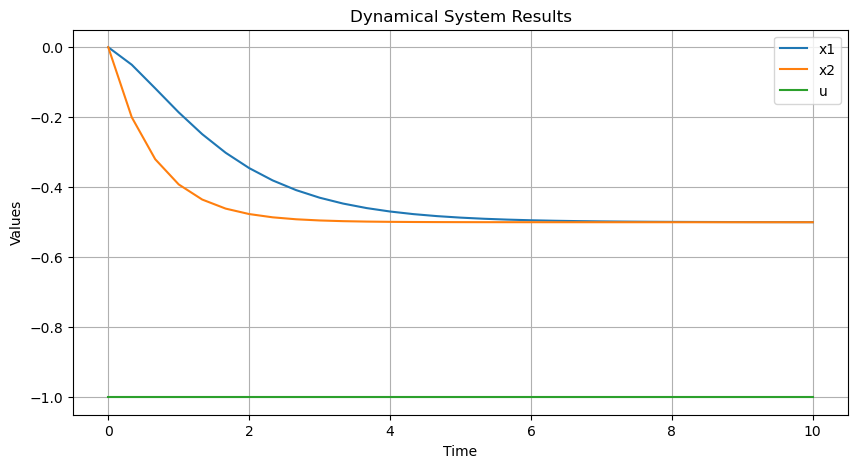

In [3]:
import matplotlib.pyplot as plt

# Extract time points
time_points = list(model.t)

# Extract values of x1 and x2
x1_values = [model.x1[t]() for t in time_points]
x2_values = [model.x2[t]() for t in time_points]
u_values = [model.u[t]() for t in time_points]

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(time_points, x1_values, label='x1')
plt.plot(time_points, x2_values, label='x2')
plt.plot(time_points, u_values, label='u')
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Dynamical System Results')
plt.legend()
plt.grid(True)
plt.show()

## Store Synthetic Data

In [4]:
import numpy as np
import pandas as pd

# Set the seed for reproducibility
np.random.seed(42)

# Add normally distributed noise to x1 and x2
x1_data = x1_values + np.random.normal(0, 0.1, len(x1_values))
x2_data = x2_values + np.random.normal(0, 0.1, len(x2_values))

# Create a dataframe to store the data
data = pd.DataFrame({
    't': time_points,
    'x1': x1_data,
    'x2': x2_data,
    'u': u_values
})

data.head()

,t,x1,x2,u
0,0.000000,0.049671,0.185228,-1
1,0.333333,-0.063826,-0.201350,-1
2,0.666667,-0.052731,-0.425771,-1
3,1.000000,-0.033822,-0.309746,-1
4,1.333333,-0.271809,-0.557284,-1


## Define Functions for ParmEst and Pyomo.DoE

In [5]:
from pyomo.contrib.doe import DesignOfExperiments
from pyomo.contrib.parmest.experiment import Experiment
import pyomo.contrib.parmest.parmest as parmest

In [6]:
class LinearDynamicalSystem(Experiment):
    def __init__(self, data, theta_init=None):
        self.data = data
        if theta_init is None:
            self.theta_init = {'a11': -1.0, 'a22': -2.0, 'b1': 0.0}
        else:
            self.theta_init = theta_init
        self.model = None


    def create_model(self):
        self.model = ConcreteModel()

        # Define time
        self.model.t = ContinuousSet(bounds=[0, 10])

        # Define variables
        self.model.x1 = Var(self.model.t, bounds=(-30,30), initialize=0)
        self.model.x2 = Var(self.model.t, bounds=(-30,30), initialize=0)
        self.model.u = Var(self.model.t, bounds=(-2,2), initialize=0)

        # Define derivatives
        self.model.dx1dt = DerivativeVar(self.model.x1, wrt=self.model.t)
        self.model.dx2dt = DerivativeVar(self.model.x2, wrt=self.model.t)

        # Define parameters
        self.model.a11 = Var(initialize=self.theta_init['a11'])
        self.model.a12 = Var(initialize=1.0)
        self.model.a21 = Var(initialize=0.0)
        self.model.a22 = Var(initialize=self.theta_init['a22'])
        self.model.b1 = Var(initialize=self.theta_init['b1'])
        self.model.b2 = Var(initialize=1)

        # Define differential equations
        '''
        def _ode1(m, t):
            return m.dx1dt[t] == m.a11 * m.x1[t] + m.a12*m.x2[t] + m.b1 * m.u[t]
        self.model.ode1 = Constraint(self.model.t, rule=_ode1)
        '''
        @self.model.Constraint(self.model.t)
        def ode1(m, t):
            return m.dx1dt[t] == m.a11 * m.x1[t] + m.a12*m.x2[t] + m.b1 * m.u[t]

        '''
        def _ode2(m, t):
            return m.dx2dt[t] == m.a21 * m.x1[t] + m.a22*m.x2[t] + m.b2 * m.u[t]
        self.model.ode2 = Constraint(self.model.t, rule=_ode2)
        '''
        @self.model.Constraint(self.model.t)
        def ode2(m, t):
            return m.dx2dt[t] == m.a21 * m.x1[t] + m.a22*m.x2[t] + m.b2 * m.u[t]
        
        return None

    def finalize_model(self):

        m = self.model

        # Update time discretization
        time = self.data['t'].to_numpy()
        # m.t.update((min(time), max(time)))
        m.t.update(time)
        m.t.set_changed(True)

        # Set initial points
        m.x1[0].fix(self.data['x1'].iloc[0])
        m.x2[0].fix(self.data['x2'].iloc[0])

        # Fix parameter values
        m.a11.fix()
        m.a12.fix()
        m.a21.fix()
        m.a22.fix()
        m.b1.fix()
        m.b2.fix()

        m.var_input = Suffix(direction=Suffix.LOCAL)
        m.var_input[m.u] = {0: -1}

        '''
        sim = Simulator(m, package='scipy')
        tsim, profiles = sim.simulate(
                numpoints=100, integrator='vode'
            )
        sim.initialize_model()
        '''
        
        # Discretize the model using finite difference method
        discretizer = TransformationFactory('dae.finite_difference')
        discretizer.apply_to(m, nfe=len(time)-1, scheme='BACKWARD', wrt=m.t)

        # discretizer = TransformationFactory('dae.collocation')
        # discretizer.apply_to(m, nfe=len(time)-1, ncp=3, wrt=m.t)

        # Fix the input values
        for i,t in enumerate(self.data['t']):
            m.u[t].fix(self.data['u'].iloc[i])

        return None
        

    def label_experiment(self):
        m = self.model

        time = self.data['t'].to_numpy()
        x1_data = self.data['x1'].to_numpy()
        x2_data = self.data['x2'].to_numpy()

        # print("len(m.t): ", len(m.t))
        # print("len(x1_data): ", len(x1_data))

        # Set measurement labels
        m.experiment_outputs = Suffix(direction=Suffix.LOCAL)

        # Add x1 measurement outputs
        m.experiment_outputs.update((m.x1[t], x1_data[i]) for i,t in enumerate(time))

        # Add x2 measurement outputs
        m.experiment_outputs.update((m.x2[t], x2_data[i]) for i,t in enumerate(time))

        # Add measurement error
        measurement_error = 0.1
        m.measurement_error = Suffix(direction=Suffix.LOCAL)
        m.measurement_error.update( (m.x1[t], measurement_error) for t in m.t)
        m.measurement_error.update( (m.x2[t], measurement_error) for t in m.t)

        # Specify experiment design variables (inputs)
        m.experiment_inputs = Suffix(direction=Suffix.LOCAL)
        m.experiment_inputs.update( (m.u[t], None) for t in m.t)

        # Add unknown parameter labels
        m.unknown_parameters = Suffix(direction=Suffix.LOCAL)
        m.unknown_parameters.update((k, value(k)) for k in [m.a11, m.a22, m.b1])

        return None

    def get_labeled_model(self):
        if self.model is None:
            self.create_model()
            self.finalize_model()
            self.label_experiment()
        return self.model

In [7]:
model_exp = LinearDynamicalSystem(data).get_labeled_model()

In [8]:
solver = SolverFactory('ipopt')
solver.solve(model_exp, tee=True)

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

{'Problem': [{'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 122, 'Number of variables': 122, 'Sense': 'unknown'}], 'Solver': [{'Status': 'ok', 'Message': 'Ipopt 3.13.2\\x3a Optimal Solution Found', 'Termination condition': 'optimal', 'Id': 0, 'Error rc': 0, 'Time': 0.018324851989746094}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [9]:
model_exp.pprint()

11 Var Declarations
    a11 : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :  None :  -1.0 :  None :  True :  True :  Reals
    a12 : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :  None :   1.0 :  None :  True :  True :  Reals
    a21 : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :  None :   0.0 :  None :  True :  True :  Reals
    a22 : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :  None :  -2.0 :  None :  True :  True :  Reals
    b1 : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :  None :   0.0 :  None :  True :  True :  Reals
    b2 : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :  None :     1 :  None :  True :  True :  Reals
    dx1dt : Size=31, Index=t
        Key      : Lower : Value   

## Parameter Estimation

In [10]:
exp = LinearDynamicalSystem(data)

In [11]:
pest = parmest.Estimator([exp, ], obj_function='SSE', tee=True)

obj, theta = pest.theta_est()

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

In [12]:
pest.ef_instance.pprint()

11 Var Declarations
    a11 : Size=1, Index=None
        Key  : Lower : Value               : Upper : Fixed : Stale : Domain
        None :  None : -0.9058113399604361 :  None : False : False :  Reals
    a12 : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :  None :   1.0 :  None :  True :  True :  Reals
    a21 : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :  None :   0.0 :  None :  True :  True :  Reals
    a22 : Size=1, Index=None
        Key  : Lower : Value               : Upper : Fixed : Stale : Domain
        None :  None : -1.9218129046026127 :  None : False : False :  Reals
    b1 : Size=1, Index=None
        Key  : Lower : Value                 : Upper : Fixed : Stale : Domain
        None :  None : -0.019277279050240386 :  None : False : False :  Reals
    b2 : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :  None :     1 :  None :

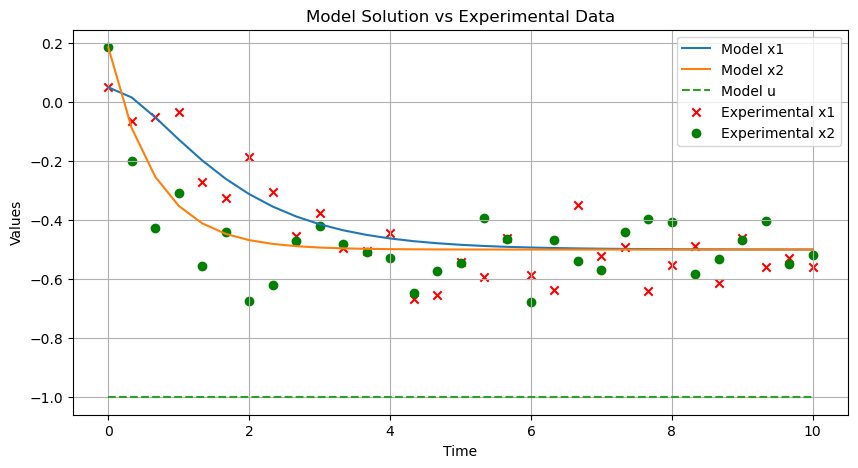

In [13]:
def plot_results(model, data=None):

    time = [value(t) for t in model.t]
    x1 = [value(model.x1[t]) for t in model.t]
    x2 = [value(model.x2[t]) for t in model.t]
    u = [value(model.u[t]) for t in model.t]

    # Plot the solution of the model
    plt.figure(figsize=(10, 5))
    plt.plot(time, x1, label='Model x1')
    plt.plot(time, x2, label='Model x2')
    plt.plot(time, u, label='Model u', linestyle='--')
    if data is not None:
        plt.scatter(data['t'], data['x1'], color='red', label='Experimental x1', marker='x')
        plt.scatter(data['t'], data['x2'], color='green', label='Experimental x2', marker='o')
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.title('Model Solution vs Experimental Data')
    plt.legend()
    plt.grid(True)
    plt.show()

    return None

plot_results(model_exp, data)

## Optimal Experiment Design

In [14]:
exp2 = LinearDynamicalSystem(data, theta_init=theta)

doe = DesignOfExperiments(experiment = exp2,
                          step = 1e-2,
                          scale_constant_value=1,
                          scale_nominal_param_value=False,
                          tee=True)

FIM_prior = doe.compute_FIM(method='sequential')


print(FIM_prior)

[[ 66.82815317  35.1585479  138.26328541]
 [ 35.1585479   36.82931758  74.38588772]
 [138.26328541  74.38588772 307.9838091 ]]


In [15]:
exp3 = LinearDynamicalSystem(data, theta_init=theta)

doe_opt = DesignOfExperiments(experiment = exp3,
                                step = 1e-2,
                                scale_constant_value=1,
                                scale_nominal_param_value=False,
                                objective_option="determinant",
                                prior_FIM=FIM_prior,
                                tee=True)

doe_opt.run_doe()

Ipopt 3.13.2: linear_solver=ma57
halt_on_ampl_error=yes
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for

In [16]:
doe_opt.model.scenario_blocks[0]

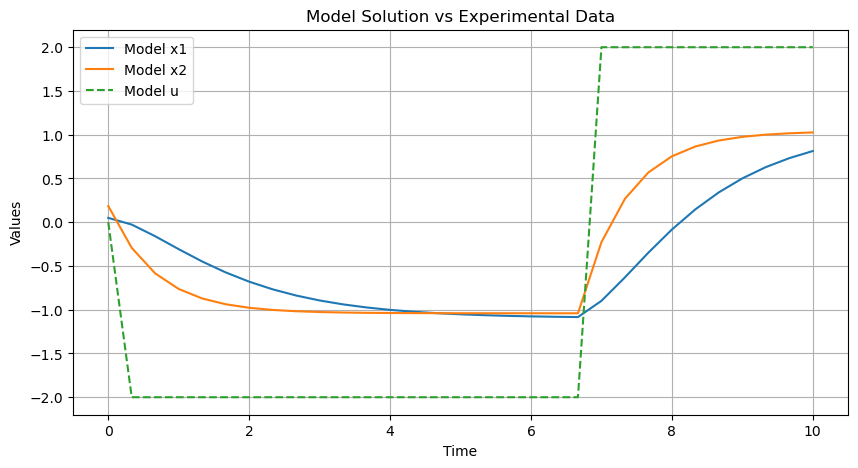

In [17]:
plot_results(doe_opt.model.scenario_blocks[0])